In [47]:
# DO NOT RUN pre-process 5 day data
# import re
# import glob
# import pandas as pd
# day_pattern = re.compile(r'[Dd]ay[_]?(\d+)')
# 
# csv_files = glob.glob("data/*.csv")
# 
# for file in csv_files:
#     match = day_pattern.search(file)
#     if not match:
#         continue
# 
#     day_num = int(match.group(1))
#     days_left = 6 - day_num
# 
#     df = pd.read_csv(file)
# 
#     df['days_left'] = days_left
# 
#     output_file = file.replace(".csv", "_with_days_left.csv")
#     df.to_csv(output_file, index=False)


In [179]:
# load the data
import os
import glob
import pandas as pd

data_folder = "data"

csv_files = glob.glob(os.path.join(data_folder, "*_with_days_left.csv"))

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)
    print(f"Loaded {os.path.basename(file)} ({len(df)} rows)")

combined_df = pd.concat(dfs, ignore_index=True)

# Filter out rows where any feature is 0
feature_cols = ['temperature', 'humidity', 'avg_R', 'avg_G', 'avg_B']
cleaned_df = combined_df[(combined_df[feature_cols] != 0).all(axis=1)]

print(f"Rows before cleaning: {len(combined_df)}")
print(f"Rows after cleaning: {len(cleaned_df)}")

Loaded day_2_left_with_days_left.csv (48 rows)
Loaded day1_right_with_days_left.csv (21 rows)
Loaded day1_left_with_days_left.csv (77 rows)
Loaded Day_5_left_3.357_with_days_left.csv (71 rows)
Loaded day_4_right_with_photo_with_days_left.csv (7 rows)
Loaded Day_3_left_with_photo_with_days_left.csv (20 rows)
Loaded day_2_right_with_days_left.csv (38 rows)
Loaded Day_3_right_with_photo_with_days_left.csv (20 rows)
Loaded Day_5_right_3.346_with_days_left.csv (15 rows)
Loaded day_4_left_with_photo_with_days_left.csv (38 rows)
Rows before cleaning: 355
Rows after cleaning: 350


   temperature  humidity  avg_R  avg_G  avg_B
0         27.7      50.8     46     42     40
Fitting 5 folds for each of 18 candidates, totalling 90 fits
=== GridSearchCV results ===
Best params: {'model__alpha': 0.001, 'poly__degree': 3}
Test set Mean Absolute Error: 0.085
Test set R² Score: 0.995


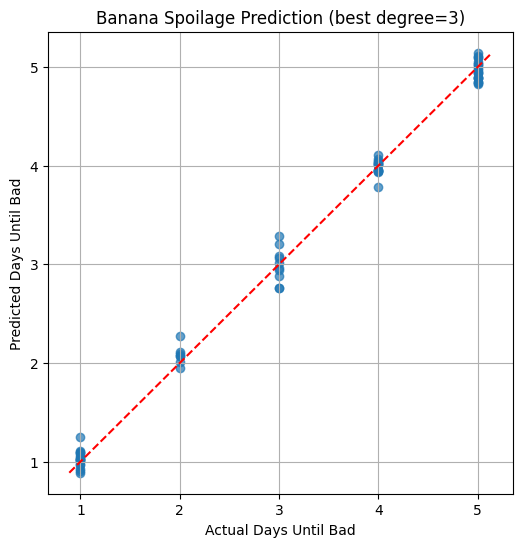


Predicted days until bad for new sample: 3.81 days


In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

# Features and target
X = cleaned_df[feature_cols]
print(X.head(n=1))
y = cleaned_df['days_left']


# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scale', StandardScaler()),
    ('model', Ridge())
])

param_grid = {
    'poly__degree': [1, 2, 3],
    'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
}

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("=== GridSearchCV results ===")
print("Best params:", search.best_params_)

best_model = search.best_estimator_

# evaluate on test set
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test set Mean Absolute Error: {mae:.3f}")
print(f"Test set R² Score: {r2:.3f}")

# plot predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
minv = min(y_test.min(), y_pred.min())
maxv = max(y_test.max(), y_pred.max())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel("Actual Days Until Bad")
plt.ylabel("Predicted Days Until Bad")
plt.title(f"Banana Spoilage Prediction (best degree={search.best_params_['poly__degree']})")
plt.grid(True)
plt.show()

# predict for new banana
new_sample = np.array([[27.7, 50.8, 46, 42, 40]])  # R,G,B,gas,temp,humidity
predicted_day = best_model.predict(new_sample)[0]
print(f"\nPredicted days until bad for new sample: {predicted_day:.2f} days")

best_degree = search.best_params_['poly__degree']
if best_degree == 1:
    coef = best_model.named_steps['model'].coef_
    feature_names = best_model.named_steps['poly'].get_feature_names_out(X.columns)
    coeffs_df = pd.DataFrame({'feature': feature_names, 'coef': coef})
    print("\nModel coefficients (degree=1):")
    print(coeffs_df)


In [193]:
import colorsys
import numpy as np

def rgb_to_ripeness(r, g, b):
    # normalize RGB to [0,1]
    r_norm, g_norm, b_norm = r/255.0, g/255.0, b/255.0
    h, s, v = colorsys.rgb_to_hsv(r_norm, g_norm, b_norm)
    
    h_deg = h * 360
    
    # green ~120°, yellow ~60°, brown ~30°, black ~0°
    ripeness = (120 - h_deg)/120  # scale roughly 0 (green) → 1 (brown/black)
    ripeness = np.clip(ripeness, 0, 1)
    return ripeness

cleaned_df['ripeness'] = cleaned_df.apply(lambda row: rgb_to_ripeness(row['avg_R'], row['avg_G'], row['avg_B']), axis=1)

feature_cols = ['temperature', 'humidity', 'ripeness']

   temperature  humidity  ripeness
0         27.7      50.8  0.833333
Fitting 5 folds for each of 18 candidates, totalling 90 fits
=== GridSearchCV results ===
Best params: {'model__alpha': 0.0001, 'poly__degree': 3}
Test set Mean Absolute Error: 0.143
Test set R² Score: 0.980


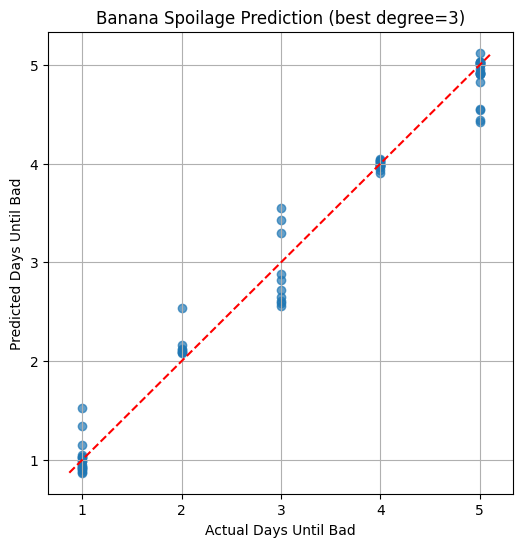

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

# Features and target
X = cleaned_df[feature_cols]
print(X.head(n=1))
y = cleaned_df['days_left']


# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scale', StandardScaler()),
    ('model', Ridge())
])

param_grid = {
    'poly__degree': [1, 2, 3],
    'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
}

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("=== GridSearchCV results ===")
print("Best params:", search.best_params_)

best_model = search.best_estimator_

# evaluate on test set
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test set Mean Absolute Error: {mae:.3f}")
print(f"Test set R² Score: {r2:.3f}")

# plot predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
minv = min(y_test.min(), y_pred.min())
maxv = max(y_test.max(), y_pred.max())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel("Actual Days Until Bad")
plt.ylabel("Predicted Days Until Bad")
plt.title(f"Banana Spoilage Prediction (best degree={search.best_params_['poly__degree']})")
plt.grid(True)
plt.show()

In [195]:
# save the model
import joblib

# Save the trained pipeline to a file
model_filename = "banana_spoilage_model.pkl"
joblib.dump(best_model, model_filename)

['banana_spoilage_model.pkl']

In [196]:
# Load the saved model
loaded_model = joblib.load("banana_spoilage_model.pkl")
ripeness = rgb_to_ripeness(175, 175, 16)
new_sample = np.array([[27.7, 50.8, ripeness]])  # temperature, humidity, ripeness

# Predict using the loaded model
predicted_days = loaded_model.predict(new_sample)[0]
print(f"Predicted days until bad: {predicted_days:.2f}")

Predicted days until bad: 4.31
